## Model Build Steps

#### Step 1: Create X_train_v3 and X_test_v3
* Read train and test csv files
* Make copies of train and test dataframes
* Drop constant and generic features in train and test
* One-hot-encoding: 'gender'
* Ordinal-encoding: 'age_quantile_label', 'days_reg_quantile_label','income_quantile_label'
* Drop redundant features
***
* Create df_received (base) expanded
* Create X_train_received and X_test_received using df_received_expanded 
* Create X_train_v2 and X_test_v2 by merging X_train/test_received with X_train/test
* Read transaction engagement csv data and create trans_offer_completed dataframe
* Create X_train_v3 and X_test_v3 by merging X_train/test_v2 with trans_offer_completed
* Save X_train_v3 and X_test_v3 as csv.gz files
***
#### Step 2: Scikit-learn train estimators and serialize trained estimators
* Identify unique offer_type_v2, except informational offers
* Unique Model Estimator Iterative Process: (number of unique offer_type_v2)
    * Filter each offer_type_v2 from X_train_v3 and X_test_v3 to create offer type train and test sets
    * Split offer type train and test into X_train, y_train, X_test, and y_test
    * Multicollinearity: Remove highly correlated features in X_train and X_test using Pearson and Spearman. Use set to find overlaps and overlapping features are removed with threshold >0.95.
    * Train RandomForestClassifier(random_state=0)
    * Use RF feature importance and permutation importance to identify important features, and only keep overlapping features between RFFI and PI.
    * Re-train RF model after feature selection
    * SKIP: Optimize RF hyperparameters using Randomized Search
    * Create final RF estimator and save
* This step is applied to 4 BOGOs and 4 Discounts, which will generate 8 unique model estimators
***
#### Step 3: Trained Models Output Handler Process
* Prediction outputs are merged with corresponding customer_id's; 8 predictions per customer_id
* For every customer_id, the prediction ouputs are aggregated by where model predicted "1" with predict_proba value
* For every round of offer spend time, handler function will pick offer with highest predict_proba among the predicted 1's
* If all predictions are "0", then a default offer schedule will dictate which offer the customer will receive going forward until there is enough customer data to create relevant features.

In [397]:
%matplotlib inline
import os
import json
import pickle
import random
import warnings
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

from base_transforms import BaseTransformDF

plt.style.use('seaborn')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Step 1: Create X_train_v3 and X_test_v3
* Read train and test csv files
* Make copies of train and test dataframes
* Drop constant and generic features in train and test
* One-hot-encoding: 'gender'
* Ordinal-encoding: 'age_quantile_label', 'days_reg_quantile_label','income_quantile_label'
* Drop redundant features
* Create df_received (base) expanded
* Create X_train_v2 and X_test_v2 by merging X_train/test_received with X_train/test
    * Create X_train_received and X_test_received using df_received_expanded as left dataframes
* Read transaction engagement csv data and create trans_offer_completed dataframe
* Create X_train_v3 and X_test_v3 by merging X_train/test_v2 with trans_offer_completed
* Save X_train_v3 and X_test_v3 as csv.gz files

In [17]:
# read train and test csv files
def read_train_test_csv_files():
    train_file = 'train_starbucks.csv.gz'
    test_file = 'test_starbucks.csv.gz'
    train_file_gzip = os.path.join('../data', train_file)
    test_file_gzip = os.path.join('../data', test_file)
    train = pd.read_csv(train_file_gzip, compression='gzip')
    test = pd.read_csv(test_file_gzip, compression='gzip')
    return train, test

In [18]:
# drop constant features
def drop_constant_features(X):
    X = X.copy()
    DROP_CONSTANT_COLUMNS = []
    for column in X.columns:
        if X[column].nunique() == 1:
            DROP_CONSTANT_COLUMNS.append(column)
    X.drop(columns=DROP_CONSTANT_COLUMNS, inplace = True)
    return X

# drop generic features
def drop_generic_features(X):
    X = X.copy()
    DROP_GENERIC_COLUMNS = ['gender_NA', 'income_NA', 'age_NA']
    X.drop(columns=DROP_GENERIC_COLUMNS, inplace = True)
    return X

In [19]:
# one hot encoding of gender feature into gender_F, gender_M, and gender_Missing
def gender_one_hot_encoder(train, test):
    """
    :param train: train dataframe
    :param test: test dataframe
    :return: outputs train, test dataframes
    """
    # make copies
    X_train = train.copy()
    X_test = test.copy()
    
    # Re-label 'O' to 'Missing' for gender
    X_train['gender'] = X_train['gender'].apply(lambda x: 'Missing' if x == 'O' else x)
    X_test['gender'] = X_test['gender'].apply(lambda x: 'Missing' if x == 'O' else x)

    # integer encode
    label_encoder = LabelEncoder()
    train_integer_encoded = label_encoder.fit_transform(X_train.gender)
    test_integer_encoded = label_encoder.transform(X_test.gender)

    # binary encode
    n_train = len(train_integer_encoded)
    n_test = len(test_integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    train_integer_encoded_reshaped = train_integer_encoded.reshape(n_train, 1)
    test_integer_encoded_reshaped = test_integer_encoded.reshape(n_test, 1)
    train_onehot_encoded = onehot_encoder.fit_transform(train_integer_encoded_reshaped)
    test_onehot_encoded = onehot_encoder.transform(test_integer_encoded_reshaped)

    # create column names and append one-hot-encoded gender columns to X_train and X_test
    train_label_mapping = [item for item in zip(train_integer_encoded, np.array(X_train.gender))]
    train_label_mapping = sorted(set(train_label_mapping))
    train_column_names = ['gender_' + i[1] for i in train_label_mapping]    
    train_ohe_gender = pd.DataFrame(train_onehot_encoded, columns=train_column_names)
    X_train = pd.concat([X_train, train_ohe_gender], axis=1)

    test_label_mapping = [item for item in zip(test_integer_encoded, np.array(X_test.gender))]
    test_label_mapping = sorted(set(test_label_mapping))
    test_column_names = ['gender_' + i[1] for i in test_label_mapping]
    test_ohe_gender = pd.DataFrame(test_onehot_encoded, columns=test_column_names)
    X_test = pd.concat([X_test, test_ohe_gender], axis=1)
    return X_train, X_test

In [20]:
def ordinal_feature_encoder(train, test):
    # make copies
    X_train = train.copy()
    X_test = test.copy()
    # ordinal (categorical) encoding
    ORDINAL_COLUMNS = ['age_quantile_label', 'days_reg_quantile_label','income_quantile_label']
    # integer encode
    label_encoder = LabelEncoder()
    for column in ORDINAL_COLUMNS:
        train_labels = X_train[column]
        test_labels = X_test[column]
        train_integer_encoded = label_encoder.fit_transform(train_labels)
        test_integer_encoded = label_encoder.transform(test_labels)

        adj_column = column + '_enc'
        train_column = pd.DataFrame(train_integer_encoded, columns=[adj_column])
        test_column = pd.DataFrame(test_integer_encoded, columns=[adj_column])
        X_train = pd.concat([X_train, train_column], axis=1)
        X_test = pd.concat([X_test, test_column], axis=1)
    return X_train, X_test

In [21]:
# drop redundant features
def drop_redundant_features(X):
    DROP_REDUNDANT_COLUMNS = ['gender', 'age_quantile_range', 'date_registered', 
                              'age_quantile_label', 'days_reg_quantile_label','income_quantile_label', 
                              'days_reg_quantile_range', 'income_quantile_range']
    X.drop(columns=DROP_REDUNDANT_COLUMNS, inplace=True)
    return X

In [27]:
def create_train_test_v1():
    # step 1: read csv files
    train, test = read_train_test_csv_files()
    # step 2: drop constant features
    X_train = drop_constant_features(train)
    X_test = drop_constant_features(test)
    # step 3: drop generic features
    X_train = drop_generic_features(X_train)
    X_test = drop_generic_features(X_test)
    # step 4: feature transformers: one hot and ordinal encoding
    X_train, X_test = gender_one_hot_encoder(X_train, X_test)
    X_train, X_test = ordinal_feature_encoder(X_train, X_test)    
    # step 5: drop redundant features
    X_train = drop_redundant_features(X_train)
    X_test = drop_redundant_features(X_test)
    return X_train, X_test

X_train, X_test = create_train_test_v1()

In [28]:
# create offer_type_v2 with apply function
def _create_offer_type_v2(df):
    """Used in lambda function across columns in dataframe"""
    rw = str(df.reward)
    dif = str(df.difficulty)
    dur = str(df.duration)
    otype = df.offer_type
    offer_type_v2 = otype+'-'+rw+'-'+dif+'-'+dur
    return offer_type_v2

def create_portfolio_expanded():
    portfolio = pd.read_json('../data/portfolio.json', orient='records', lines=True)
    portfolio_exp = BaseTransformDF.portfolio_expanded(portfolio)
    portfolio_exp['offer_type_v2'] = portfolio_exp.apply(_create_offer_type_v2, axis=1)
    portfolio_exp.drop(columns=['channels'], inplace=True)
    return portfolio_exp

In [29]:
def create_received_expanded():
    # create base transcript df
    transcript = pd.read_json('../data/transcript.json', orient='records', lines=True)
    base_transcript = BaseTransformDF.create_transcript_copy(transcript)
    base_received = BaseTransformDF.create_df_base_received(base_transcript)
    # create portfolio expanded df using create_portfolio_expanded() function
    portfolio_exp = create_portfolio_expanded()
    # merge dataframes to create expanded offers received
    received_exp = base_received.merge(portfolio_exp, how='left', on='offer_id')
    received_exp.drop(columns=['offer_received'], inplace=True)
    return received_exp

In [30]:
def create_train_test_v2(X):
    received_expanded = create_received_expanded()
    X_customer_ids = X.customer_id.reset_index().drop(columns=['index'])
    X_received = received_expanded.merge(X_customer_ids, how='inner', on='customer_id')
    X_v2 = X_received.merge(X, how='left', on='customer_id')
    return X_v2

X_train_v2 = create_train_test_v2(X_train)
X_test_v2 = create_train_test_v2(X_test)

In [31]:
def create_train_test_v3(X_v2):
    # read transaction engagement csv file
    file_name = 'starbucks_transaction_engagement.csv.gz' 
    file_gzip = os.path.join('../data', file_name)
    trans_engage = pd.read_csv(file_gzip, compression='gzip')

    # using transaction engagement data mart isolate all transaction_id's with offer_completed = 1
    selected_columns = ['customer_id', 'offer_id', 'offer_completed', 
                        'offer_completed_time', 'offer_received_time']
    trans_offer_completed = trans_engage[selected_columns][trans_engage.offer_completed == 1]
    trans_offer_completed.drop_duplicates(inplace=True)

    # join by customer_id, offer_id, and offer_received_time
    X_v3 = X_v2.merge(trans_offer_completed, how='left', on=['customer_id', 'offer_id', 'offer_received_time'])
    X_v3.drop_duplicates(inplace=True)
    X_v3['offer_completed'].fillna(0, inplace=True)
    X_v3['offer_completed_time'].fillna(-1, inplace=True)
    return X_v3

X_train_v3 = create_train_test_v3(X_train_v2)
X_test_v3 = create_train_test_v3(X_test_v2)

In [34]:
print(X_train_v3.shape)
print(X_test_v3.shape)

(51116, 64)
(25242, 64)


#### Save X_train_v3 & X_test_v3 as csv.gzip files

In [32]:
# write df to gzipped csv file
data_dir = '../data'
train_v3_file = 'train_v3_starbucks.csv.gz'
test_v3_file = 'test_v3_starbucks.csv.gz'

train_v3_file_path = os.path.join(data_dir, train_v3_file)
test_v3_file_path = os.path.join(data_dir, test_v3_file)

try:
    X_train_v3.to_csv(train_v3_file_path, index=False, compression='gzip')
    print("Success: {} created".format(train_v3_file))
    print("  File_path_name: {}".format(train_v3_file_path))
    X_test_v3.to_csv(test_v3_file_path, index=False, compression='gzip')
    print("Success: {} created".format(test_v3_file))
    print("  File_path_name: {}".format(test_v3_file_path))
except:
    print("Error: File creations failed.")

Success: train_v3_starbucks.csv.gz created
  File_path_name: /Users/dlee/ds/repos/udacity-starbucks-capstone-project/data/train_v3_starbucks.csv.gz
Success: test_v3_starbucks.csv.gz created
  File_path_name: /Users/dlee/ds/repos/udacity-starbucks-capstone-project/data/test_v3_starbucks.csv.gz


## Step 2: Scikit-learn Model Training and Model Serialization
* Identify unique offer_type_v2, except informational offers
* Unique Model Estimator Iterative Process: (number of unique offer_type_v2)
    * Filter each offer_type_v2 from X_train_v3 and X_test_v3 to create offer type train and test sets
    * Split offer type train and test into X_train, y_train, X_test, and y_test
    * Multicollinearity: Remove highly correlated features in X_train and X_test using Pearson and Spearman. Use set to find overlaps and overlapping features are removed with threshold >0.95.
    * Train RandomForestClassifier(random_state=0)
    * Use RF feature importance and permutation importance to identify important features, and only keep overlapping features between RFFI and PI.
    * Re-train RF model after feature selection
    * Optimize RF hyperparameters using Randomized Search
    * Create final RF estimator and save
* This step is applied to 4 BOGOs and 4 Discounts, which will generate 8 unique model estimators

In [97]:
def read_train_test_v3_csv_files():
    train_file = 'train_v3_starbucks.csv.gz'
    test_file = 'test_v3_starbucks.csv.gz'
    train_file_gzip = os.path.join('../data', train_file)
    test_file_gzip = os.path.join('../data', test_file)
    train_v3 = pd.read_csv(train_file_gzip, compression='gzip')
    test_v3 = pd.read_csv(test_file_gzip, compression='gzip')
    return train_v3, test_v3

In [197]:
def feature_importance_ranking(train_data, n_features, feature_importance_scores):
    """
    train_data: training pandas dataframe data
    n_features: an integer; number of features in X_train
    feature_importance_scores: numpy ndarray from sklearn.ensemble.RandomForestClassifier.feature_importances_
    """
    feature_importances = {}
    for idx in range(n_features):
        key = train_data.columns[idx]
        val = feature_importance_scores[idx]
        feature_importances[key] = val
    important_features = pd.DataFrame.from_dict(feature_importances, orient='index', columns=['importance'])
    ranked_features = important_features.sort_values('importance', ascending=False)
    return ranked_features


def permutation_importance_ranking(train_data, importances, sorted_idx):
    feature_names = train_data.columns[sorted_idx]
    feature_perm_imp_vals = importances.importances_mean[sorted_idx]
    feature_perm_dict = {}
    for idx in range(len(feature_names)):
        k = feature_names[idx]
        v = feature_perm_imp_vals[idx]
        feature_perm_dict[k] = v
    perm_imp = pd.DataFrame.from_dict(feature_perm_dict, orient='index', columns=['importance'])
    return perm_imp

In [230]:
# feature selection
# offer type dictionary: {offer_type: list_of_selected_features} 
def feature_selection_per_offer_type(X):
    X = X.copy()
    offer_types = X[X.offer_type != 'informational'].offer_type_v2.unique().tolist()
    
    DROP_COLUMNS = ['customer_id', 'reward', 'difficulty', 'duration', 'num_channels',
                    'ch_web', 'ch_email', 'ch_mobile', 'ch_social', 'type_bogo', 'type_informational', 
                    'type_discount', 'offer_id', 'offer_type', 'offer_type_v2', 'offer_completed_time']
    
    features_per_offer_type = {}
    for offer_type in offer_types:
        train = X[X.offer_type_v2==offer_type]
        train.drop(columns=DROP_COLUMNS, inplace=True)
        train.drop_duplicates(inplace=True)
        
        # create X and y sets
        X_train = train.iloc[:, :-1]
        y_train = train.iloc[:, -1:]
        # identify correlated features and drop
        corr_matrix = X_train.corr().abs()
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
        DROP_CORRELATED_COLUMNS = [col for col in upper_tri.columns if any(upper_tri[col] > 0.95)]
        X_train.drop(columns=DROP_CORRELATED_COLUMNS, inplace=True)
        print("Correlated features dropped.")
        
        # RF feature importances
        rf_estimator = RandomForestClassifier(random_state=0)
        rf_estimator.fit(X_train, y_train)
        rf_imp = feature_importance_ranking(X_train, len(X_train.columns), rf_estimator.feature_importances_)
        # set arbitrary importance threshold
        rf_imp = rf_imp[rf_imp.importance >= 0.01]
        print("RF feature importances identified.")
        
        # permutation importances
        perm_importances = permutation_importance(rf_estimator, X_train, y_train, n_repeats=10, random_state=0)
        perm_sorted_idx = perm_importances.importances_mean.argsort()[::-1]
        perm_imp = permutation_importance_ranking(X_train, perm_importances, perm_sorted_idx)
        # set arbitrary importance threshold 
        perm_imp = perm_imp[perm_imp.importance >= 0.001]
        print("Permutation feature importances identified.")
        
        # identify features intersecting between RF feat imp and perm imp
        feature_set = list(rf_imp.index.intersection(perm_imp.index))
        print("Intersecting features identified between RF Feature Importances and Permutation Importances.")
        # add to dictionary
        features_per_offer_type[offer_type] = feature_set
        print("{} feature set created.".format(offer_type))
        print("")
    return features_per_offer_type

# save feature set per offer_type_v2 as json file
def serialize_feature_sets(feature_sets):
    # serialize feature_sets dictionary to be used later
    with open("../trained_models/training_feature_sets.json", "w") as outfile: 
        json.dump(feature_sets, outfile)
        print("Serialization complete: Model feature sets saved.")
        print("  File_path_name: trained_models/training_feature_sets.json")

In [231]:
%%time
# read in X v3 csv files
X_train_v3, X_test_v3 = read_train_test_v3_csv_files()

# generate model feature sets using feature_selection_per_offer_type function
feature_sets = feature_selection_per_offer_type(X_train_v3)

# execute to serialize feature sets as json
serialize_feature_sets(feature_sets)

Correlated features dropped.
RF feature importances identified.
Permutation feature importances identified.
Intersecting features identified between RF Feature Importances and Permutation Importances.
bogo-5-5-168 feature set created.

Correlated features dropped.
RF feature importances identified.
Permutation feature importances identified.
Intersecting features identified between RF Feature Importances and Permutation Importances.
bogo-10-10-168 feature set created.

Correlated features dropped.
RF feature importances identified.
Permutation feature importances identified.
Intersecting features identified between RF Feature Importances and Permutation Importances.
bogo-5-5-120 feature set created.

Correlated features dropped.
RF feature importances identified.
Permutation feature importances identified.
Intersecting features identified between RF Feature Importances and Permutation Importances.
discount-5-20-240 feature set created.

Correlated features dropped.
RF feature importanc

In [252]:
# Serialize trained model instances and save to disk -> trained_models directory  
# Generate predictions with columns, cid, y_test, y_predict, y_pred_proba -> output/predictions directory
def train_serialize_clf_estimators():
    X_train_v3, X_test_v3 = read_train_test_v3_csv_files()
    
    with open("../trained_models/training_feature_sets.json") as json_file:
        feature_sets = json.load(json_file)
    
    accuracy_scores = {}
    for offer_type, feature_set in feature_sets.items():
        # ---- train model ---- #
        train = X_train_v3[X_train_v3.offer_type_v2==offer_type]
        X_train = train[feature_set]
        y_train = train.offer_completed
        print("Training {} Model".format(offer_type))
        
        try:
            model = RandomForestClassifier(n_estimators=100, random_state=0)
            model.fit(X_train, y_train)
            print(" Success: " + offer_type + " model fitted.")
        except:
            print(" Error: Model fitting failed")
            
        file_name = 'trained_models/' + offer_type + '_model.pickle'
        with open(file_name, 'wb') as pickle_file:
            pickle.dump(model, pickle_file)
        print(" Success: Trained {} model pickled.".format(offer_type))
        
        # ---- test model ---- #
        test = X_test_v3[X_test_v3.offer_type_v2==offer_type]
        test_cid = test.customer_id.tolist()
        X_test = test[feature_set]
        y_test = test.offer_completed
        
        # model predict and pred_proba
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        y_max_pred_proba = [max(vals) for vals in y_pred_proba]
        
        df_test_pred = pd.DataFrame({'customer_id': test_cid, 
                                     'y_test': list(y_test), 
                                     'y_predict': list(y_pred), 
                                     'y_max_pred_proba': y_max_pred_proba,
                                     'y_pred_proba': list(y_pred_proba)})
        
        # write df to csv file
        df_test_pred.to_csv('../output/predictions/{}_test_predictions.csv.gz'.format(offer_type), 
                            index=False, compression='gzip')
        print("Success: {} prediction file created".format(offer_type))
        print("  File_path_name: ../output/predictions/{}_test_predictions.csv.gz".format(offer_type))
        print("")

        # ---- test accuracy scores ---- #
        accuracy_value = accuracy_score(y_test, y_pred)
        accuracy_scores[offer_type + '_accuracy_score'] = accuracy_value
    
    # display accuracy scores per offer_type
    print(accuracy_scores)
    print("")
    # serialize accuracy_test_scores dictionary to json file
    with open("../output/predictions/accuracy_test_scores.json", "w") as outfile: 
        json.dump(accuracy_scores, outfile)
        print("Serialization complete: accuracy_test_scores saved.")
        print("  File_path_name: ../output/predictions/accuracy_test_scores.json")      

In [253]:
# execute trained estimator serialization
train_serialize_clf_estimators()

Training bogo-5-5-168 Model
 Success: bogo-5-5-168 model fitted.
 Success: Trained bogo-5-5-168 model pickled.
Success: bogo-5-5-168 prediction file created
  File_path_name: output/predictions/bogo-5-5-168_test_predictions.csv.gz

Training bogo-10-10-168 Model
 Success: bogo-10-10-168 model fitted.
 Success: Trained bogo-10-10-168 model pickled.
Success: bogo-10-10-168 prediction file created
  File_path_name: output/predictions/bogo-10-10-168_test_predictions.csv.gz

Training bogo-5-5-120 Model
 Success: bogo-5-5-120 model fitted.
 Success: Trained bogo-5-5-120 model pickled.
Success: bogo-5-5-120 prediction file created
  File_path_name: output/predictions/bogo-5-5-120_test_predictions.csv.gz

Training discount-5-20-240 Model
 Success: discount-5-20-240 model fitted.
 Success: Trained discount-5-20-240 model pickled.
Success: discount-5-20-240 prediction file created
  File_path_name: output/predictions/discount-5-20-240_test_predictions.csv.gz

Training discount-2-10-240 Model
 Suc

## Step 3: Trained Models Output Handler Process
* Generate diagnotic metrics using train data
* Generate ROC AUC, accuracy, f1, precision, recall for test data
* Create recommendation generating function using the steps below
    * for random recommendation, choose among top for offer types


In [288]:
# model diagnostic metrics for train data
def output_train_model_stats(X_v3):
    """
    :param X_v3: train dataframe (X_train_v3)
    :return: diagnostic metrics dataframe
    """
    print(" ... starting calculations")
    # make copy of X; input X is X_train_v3
    X_v3 = X_v3.copy()
    # load training_feature_sets.json as dictionary
    feature_sets = json.load(open("../trained_models/training_feature_sets.json"))
    
    model_stats = {}
    column_names = ['accuracy', 'accuracy_cv_score', 'accuracy_cv_stddev', 'precision_score', 
                    'recall_score', 'f1_score', 'roc_auc_score (cross_val_score)']
    
    for offer_type, feature_set in feature_sets.items():
        # generate empty list for model diagnostic metrics
        model_scores = []
        
        # isolate offer_type data from X_v3, and create train and test data
        X_offer_v3 = X_v3[X_v3.offer_type_v2==offer_type]
        X_train = X_offer_v3[feature_set]
        y_train = X_offer_v3.offer_completed

        # load trained model from disk
        pickled_model_file = '../trained_models/{}_model.pickle'.format(offer_type)
        model = pickle.load(open(pickled_model_file, 'rb'))
        
        # calculate accuracy score and append to model_scores list
        model_scores.append(model.score(X_train, y_train))

        # implement cross validation model accuracy score
        scores = cross_val_score(model, X_train, y_train, cv=6, scoring='accuracy')
        model_scores.append(scores.mean())
        model_scores.append(scores.std())

        # implement cross validation predictions on train data
        y_cv_pred = cross_val_predict(model, X_train, y_train, cv=6)

        # calculate precision and recall
        p = precision_score(y_train, y_cv_pred)
        r = recall_score(y_train, y_cv_pred)
        model_scores.append(p)
        model_scores.append(r)

        # calculate F1 score
        f1_score = 2*(p*r)/(p+r)
        model_scores.append(f1_score)

        # calculate ROC AUC score using cross_val_score
        roc_auc_cvs = cross_val_score(model, X_train, y_train, cv=6, scoring='roc_auc').mean()
        model_scores.append(roc_auc_cvs)

        # create dictionary key/pair value
        model_stats[offer_type] = model_scores
        
        print("    {} model diagnostic metrics created.".format(offer_type))

    # put model stats into a dataframe
    df_model_stats = pd.DataFrame.from_dict(model_stats, orient='index', columns=column_names)
    df_model_stats_ranked = df_model_stats.sort_values(by='accuracy', ascending=False)
    print(" ... Finished")
    return df_model_stats_ranked

In [289]:
# load X v3 files
X_train_v3, X_test_v3 = read_train_test_v3_csv_files()

# run output_train_model_stats and generate model diagnostic metrics per offer_type
train_diagnostic_metrics = output_train_model_stats(X_train_v3)
train_diagnostic_metrics

 ... starting calculations
    bogo-5-5-168 model diagnostic metrics created.
    bogo-10-10-168 model diagnostic metrics created.
    bogo-5-5-120 model diagnostic metrics created.
    discount-5-20-240 model diagnostic metrics created.
    discount-2-10-240 model diagnostic metrics created.
    bogo-10-10-120 model diagnostic metrics created.
    discount-2-10-168 model diagnostic metrics created.
    discount-3-7-168 model diagnostic metrics created.
 ... Finished


,accuracy,accuracy_cv_score,accuracy_cv_stddev,precision_score,recall_score,f1_score,roc_auc_score (cross_val_score)
bogo-5-5-168,1.000000,0.932251,0.009086,0.900600,0.989255,0.942848,0.976598
bogo-10-10-168,1.000000,0.950275,0.007625,0.917391,0.981395,0.948315,0.985364
bogo-5-5-120,1.000000,0.918026,0.010330,0.882226,0.985838,0.931158,0.968386
discount-5-20-240,1.000000,0.940359,0.007936,0.898438,0.972841,0.934160,0.982780
bogo-10-10-120,1.000000,0.941017,0.011880,0.902900,0.968877,0.934726,0.986862
discount-2-10-168,1.000000,0.929023,0.011651,0.897180,0.977520,0.935628,0.975838
discount-3-7-168,1.000000,0.936785,0.008056,0.917950,0.995393,0.955104,0.974016
discount-2-10-240,0.999805,0.950156,0.004508,0.936311,0.995784,0.965132,0.977149


In [303]:
# model diagnostic metrics for test data
def output_test_model_stats(X_v3):
    # make copy of X_v3
    X_v3 = X_v3.copy()
    # load training_feature_sets.json as dictionary
    feature_sets = json.load(open('../trained_models/training_feature_sets.json'))
    # create empty dictionary
    model_stats = {}
    column_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'tn', 'fp', 'fn', 'tp']
    
    for offer_type, feature_set in feature_sets.items():
        # empty list
        model_scores = []
        # load pickled model
        pickled_model = '../trained_models/{}_model.pickle'.format(offer_type)
        model = pickle.load(open(pickled_model, 'rb'))
    
        # define X_test and y_test
        X_offer_v3 = X_v3[X_v3.offer_type_v2==offer_type]
        X_test = X_offer_v3[feature_set]
        y_test = X_offer_v3.offer_completed
        # model predict and pred_proba
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        y_max_pred_proba = [max(vals) for vals in y_pred_proba]
        
        # accuracy
        accuracy = model.score(X_test, y_test)
        model_scores.append(accuracy)
        # precision
        precision = precision_score(y_test, y_pred)
        model_scores.append(precision)
        # recall
        recall = recall_score(y_test, y_pred)      
        model_scores.append(recall)
        # F1 score
        f1 = (2 * precision * recall)/(precision + recall)
        model_scores.append(f1)
        # ROC AUC
        auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])
        model_scores.append(auc_score)
        # confusion matrix 
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        model_scores.append(tn)
        model_scores.append(fp)
        model_scores.append(fn)
        model_scores.append(tp)
        # append offer type metrics to dictionary
        model_stats[offer_type] = model_scores
    # create output dataframe
    df_model_stats = pd.DataFrame.from_dict(model_stats, orient='index', columns=column_names)
    return df_model_stats

In [304]:
output_test_model_stats(X_test_v3)

,accuracy,precision,recall,f1,roc_auc,tn,fp,fn,tp
bogo-5-5-168,0.931518,0.896046,0.990832,0.941058,0.975653,989,163,13,1405
bogo-10-10-168,0.947082,0.911466,0.988976,0.948640,0.979838,1178,122,14,1256
bogo-5-5-120,0.927363,0.895156,0.986832,0.938761,0.971952,898,158,18,1349
discount-5-20-240,0.945081,0.895609,0.988117,0.939591,0.985684,1311,126,13,1081
discount-2-10-240,0.948718,0.932603,0.997071,0.963760,0.975934,666,123,5,1702
bogo-10-10-120,0.939370,0.897611,0.970480,0.932624,0.987849,1303,120,32,1052
discount-2-10-168,0.920635,0.877424,0.978378,0.925155,0.975082,1111,177,28,1267
discount-3-7-168,0.938370,0.914525,0.998780,0.954797,0.974480,723,153,2,1637


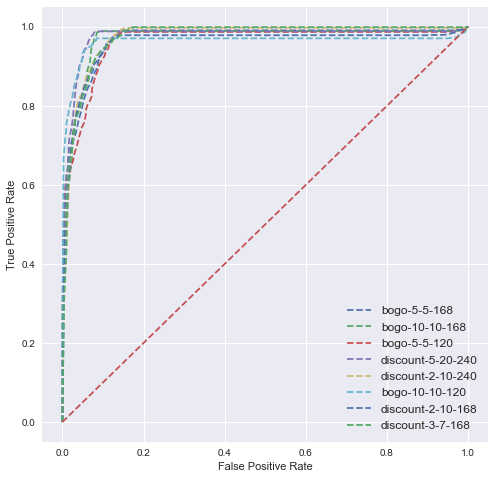

In [364]:
def _calc_success_y_pred_proba(df):
    if df.y_predict == 0:
        pred_proba = df.y_max_pred_proba - 1.0
        return pred_proba
    else:
        return df.y_max_pred_proba

fig, ax = plt.subplots(figsize=(8, 8))
for offer_type in feature_sets.keys():
    df = pd.read_csv('../output/predictions/{}_test_predictions.csv.gz'.format(offer_type), compression='gzip')
    df['y_pred_proba'] = df.apply(_calc_success_y_pred_proba, axis=1)
    
    y_test = df.y_test
    y_pred_proba = df.y_pred_proba
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
    ax.plot(fpr, tpr, linestyle='--', label=offer_type)

# roc curve for tpr = fpr 
random_probs = [0 for _ in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
ax.plot(p_fpr, p_tpr, linestyle='--')
        
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc='lower right', fontsize=12)


In [ ]:
%%time

def make_offer_recommendations(offer_type_list, top_offer_type_list, cid_list):
    # start time
    start_time = datetime.now()
    
    # dictionaries to capture random and predicted recommendations
    model_recommendations = {}
    random_recommendations = {}
    
    # counters to measure script progression
    num_customers = 0
    num_model = 0
    num_random = 0 

    for cid in cid_list:
        pred_proba_offers = {}
        for offer_type in offer_type_list:
            preds = pd.read_csv('../output/predictions/{}_test_predictions.csv.gz'.format(offer_type), 
                                compression='gzip')
            try:
                pred = preds[(preds.customer_id==cid) & (preds.y_predict==1)]
                if len(pred) != 0:
                    pred_max = pred.groupby(['customer_id', 'y_predict'])['y_max_pred_proba'].max().reset_index()
                    pred_proba_offers[offer_type] = float(pred_max.y_max_pred_proba)
            except:
                continue

        if len(pred_proba_offers) != 0:
            pred_proba_offers_sorted = sorted(pred_proba_offers.items(), key=lambda x: x[1], reverse=True)
            model_recommendations[cid] = list(pred_proba_offers_sorted[0])
            num_model += 1
        else:
            offer_type_choice = random.choice(top_offer_type_list)
            random_recommendations[cid] = offer_type_choice 
            num_random += 1

        num_customers += 1
        if num_customers % 1000 == 0:
            print("{} customer recommendations generated.".format(num_customers))
            print("    {} model recommendations generated.".format(num_model))
            print("    {} random recommendations generated.".format(num_random))
            print(" ... Process time: {}".format(datetime.now() - start_time))

    model_rec_df = pd.DataFrame.from_dict(model_recommendations, orient='index', 
                                          columns=['offer_type', 'pred_proba'])
    model_rec_df.to_csv('../output/recommendations/model_recommendations.csv.gz', 
                        index=False, compression='gzip')

    random_rec_df = pd.DataFrame.from_dict(random_recommendations, orient='index', 
                                           columns=['offer_type'])
    random_rec_df.to_csv('../output/recommendations/random_recommendations.csv.gz', 
                         index=False, compression='gzip')


if __name__ == '__main__':  
    # load training_feature_sets.json to create list of offer types
    feature_sets = json.load(open('../trained_models/training_feature_sets.json'))
    offer_types = feature_sets.keys()
    
    # top 4 offer types using rank_contribution_score for random assignment to customers without "1" predictions
    offer_funnel = pd.read_csv('../data/starbucks_offers_funnel_analysis.csv.gz', compression='gzip')
    offer_funnel = offer_funnel[offer_funnel.offer_type != 'informational']
    offer_funnel['engagement_score'] = offer_funnel['viewed_rate'] * offer_funnel['completion_rate']
    offer_funnel['normalized_difficulty'] = 1.0 * offer_funnel.difficulty / offer_funnel.duration
    offer_funnel['contribution_score'] = offer_funnel.engagement_score * (1 - offer_funnel.normalized_difficulty)
    offer_funnel['rank_contribution_score'] = offer_funnel.contribution_score.rank(method='dense', ascending=False)
    offer_funnel['offer_type_v2'] = offer_funnel.apply(lambda x: x.offer_type+'-'+str(x.reward)+'-'+str(x.difficulty)+'-'+str(x.duration), axis=1)
    top_offer_types = offer_funnel[offer_funnel.rank_contribution_score <= 4].offer_type_v2.tolist()

    # load test_v3_starbucks.csv.gz to create customer_id list
    test_v3 = pd.read_csv('../data/test_v3_starbucks.csv.gz', compression='gzip')
    cids = test_v3.customer_id.unique()
    
    # generate recommendations
    make_offer_recommendations(offer_types, top_offer_types, cids)


In [467]:
# load training_feature_sets.json to create list of offer types
feature_sets = json.load(open('../trained_models/training_feature_sets.json'))
offer_types = feature_sets.keys()

# calculate top 4 offer types based on rank_contribution_score to be used for random assignment to customers
offer_funnel = pd.read_csv('../data/starbucks_offers_funnel_analysis.csv.gz', compression='gzip')
offer_funnel = offer_funnel[offer_funnel.offer_type != 'informational']
offer_funnel['engagement_score'] = offer_funnel['viewed_rate'] * offer_funnel['completion_rate']
offer_funnel['normalized_difficulty'] = 1.0 * offer_funnel.difficulty / offer_funnel.duration
offer_funnel['contribution_score'] = offer_funnel.engagement_score * (1 - offer_funnel.normalized_difficulty)
offer_funnel['rank_contribution_score'] = offer_funnel.contribution_score.rank(method='dense', ascending=False)
offer_funnel['offer_type_v2'] = offer_funnel.apply(lambda x: x.offer_type+'-'+str(x.reward)+'-'+str(x.difficulty)+'-'+str(x.duration), axis=1)
top_offer_types = offer_funnel[offer_funnel.rank_contribution_score <= 4].offer_type_v2.tolist()

# load test_v3_starbucks.csv.gz to create customer_id list
test_v3 = pd.read_csv('../data/test_v3_starbucks.csv.gz', compression='gzip')
cids = test_v3.customer_id.unique()

# generate recommendations
make_offer_recommendations(offer_types, top_offer_types, cids)

1000 customer recommendations generated.
    743 model recommendations generated.
    257 random recommendations generated.
 ... Process time: 0:00:51.339036
2000 customer recommendations generated.
    1508 model recommendations generated.
    492 random recommendations generated.
 ... Process time: 0:01:45.254933
3000 customer recommendations generated.
    2255 model recommendations generated.
    745 random recommendations generated.
 ... Process time: 0:02:37.670718
4000 customer recommendations generated.
    3006 model recommendations generated.
    994 random recommendations generated.
 ... Process time: 0:03:30.647114
5000 customer recommendations generated.
    3745 model recommendations generated.
    1255 random recommendations generated.
 ... Process time: 0:04:24.488359
